# Anemometer Analysis
 

## Clean Data 

In [50]:
# Dependencies and Setup
import pandas as pd
from datetime import datetime, timedelta 
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.stats as st # for linear regression model
from scipy.stats import ttest_ind, ttest_rel
from matplotlib.colors import LinearSegmentedColormap

# Read in data
data_2d = pd.read_csv('data/2d_anemometer.csv') # 2d anemometer
data_3d = pd.read_csv('data/3d_anemometer.csv') # 3d anemometer

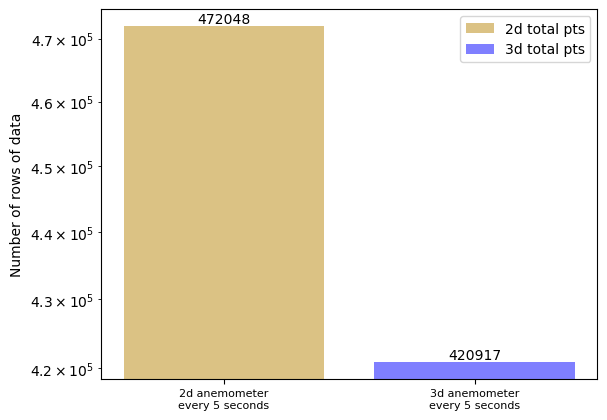

In [51]:
# Histogram of dataset sizes
dataset_sizes = [len(data_2d),len(data_3d)]
bars = plt.bar(['2d anemometer\nevery 5 seconds', 
                '3d anemometer\nevery 5 seconds'],
                 dataset_sizes, color=["darkgoldenrod","blue"],alpha=0.5,
                 label=["2d total pts","3d total pts"])
# plt.xlabel('dataset')
plt.xticks(fontsize=8)
plt.ylabel('Number of rows of data')
plt.yscale('log')
plt.legend()
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), 
             ha='center', va='bottom')  # va='bottom' to place label above the bar
plt.savefig("output/raw_data_number_data_points.png", bbox_inches='tight')
plt.show()

In [52]:
# Column names
print(data_2d.columns)
print(data_3d.columns)

Index(['_id', 'atm', 'n_pts', 'n_pts_env', 'temp', 'time_utc', 'wdr', 'wspd',
       'Origin of data', 'c.date', 'c.hour', 'c.minute', 'c.second',
       'c.second_bin'],
      dtype='object')
Index(['_id', 'n_pts', 'temp', 'time_utc', 'wdr', 'welv', 'wspd',
       'Origin of data', 'c.date', 'c.hour', 'c.minute', 'c.second',
       'c.second_bin'],
      dtype='object')


In [53]:
# Change time_utc to datetime
data_2d = data_2d.astype({
                'time_utc': 'datetime64[ns]',
                })
data_3d = data_3d.astype({
                'time_utc': 'datetime64[ns]',
                })

In [54]:
# Add seconds to the time_utc (seconds were not in original time_utc)
data_2d['time_utc'] = data_2d['time_utc'] + pd.to_timedelta(data_2d['c.second'], unit='s')
data_3d['time_utc'] = data_3d['time_utc'] + pd.to_timedelta(data_3d['c.second'], unit='s')

In [55]:
# Drop some columns
data_2d.drop(columns=['_id', 'Origin of data', 'c.date','c.hour', 'c.minute', 'c.second', 'c.second_bin','atm','n_pts_env'], inplace=True)
data_3d.drop(columns=['_id', 'Origin of data', 'c.date','c.hour', 'c.minute', 'c.second', 'c.second_bin'], inplace=True)

In [56]:
# Rename columns 
data_2d.rename(columns={
                   'temp':'temp_C',
                   'wspd':'wspd_mps',
                   },
                   inplace=True)
data_3d.rename(columns={
                   'temp':'temp_C',
                   'wspd':'wspd_mps',
                   },
                   inplace=True)

In [57]:
# Drop null values
data_2d.dropna(subset=['time_utc', 'wdr', 'wspd_mps'], inplace=True)
data_3d.dropna(subset=['time_utc', 'wdr', 'wspd_mps'], inplace=True)

In [58]:
# Show info about the dataset
data_2d.info()

<class 'pandas.core.frame.DataFrame'>
Index: 471894 entries, 0 to 472047
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   n_pts     471894 non-null  int64         
 1   temp_C    415512 non-null  float64       
 2   time_utc  471894 non-null  datetime64[ns]
 3   wdr       471894 non-null  float64       
 4   wspd_mps  471894 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 21.6 MB


In [59]:
# Show info about the dataset
data_3d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420917 entries, 0 to 420916
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   n_pts     420917 non-null  int64         
 1   temp_C    420917 non-null  float64       
 2   time_utc  420917 non-null  datetime64[ns]
 3   wdr       420917 non-null  float64       
 4   welv      420915 non-null  float64       
 5   wspd_mps  420917 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 19.3 MB


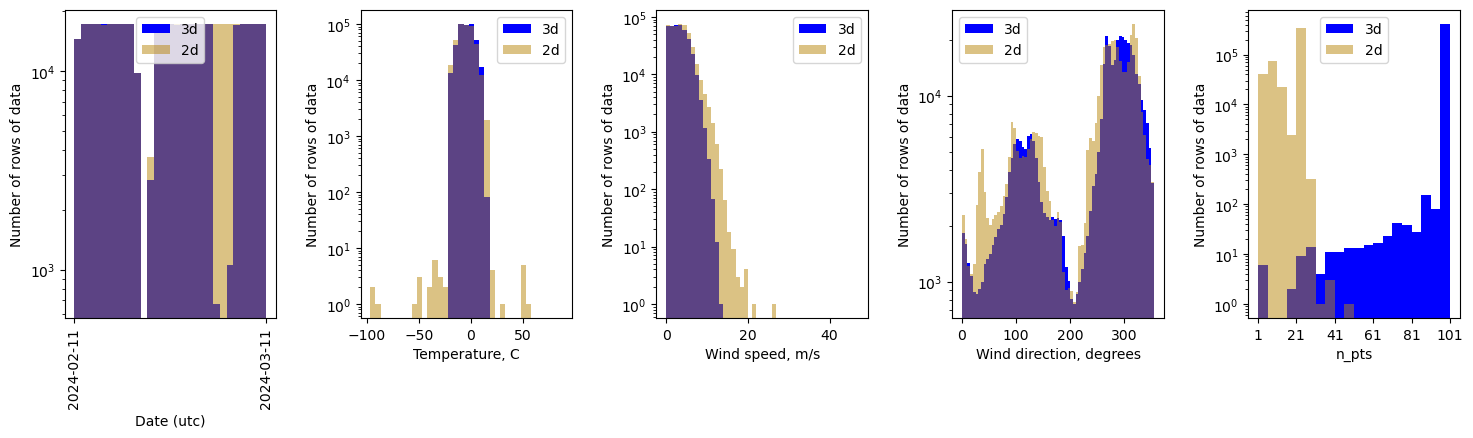

In [60]:
fig, axes = plt.subplots(1,5, figsize=(18,4))
fig.subplots_adjust(wspace=.4)

# Histogram of dates
ax = axes[0]
# Create a list of dates
start_date = min(min(data_2d['time_utc'].dt.date), min(data_3d['time_utc'].dt.date))
end_date = max(max(data_2d['time_utc'].dt.date), max(data_3d['time_utc'].dt.date))
dates = [(start_date + timedelta(days=x)).strftime('%Y-%m-%d') for x in range((end_date - start_date).days + 1)]
# Plot histogram
ax.hist(data_3d['time_utc'], bins = dates, color="blue", label="3d", alpha=1)
ax.hist(data_2d['time_utc'], bins = dates, color="darkgoldenrod", label="2d", alpha=0.5)
ax.set_xlabel('Date (utc)')  
ax.set_xticks([dates[0], dates[len(dates)-1]])
ax.tick_params(axis='x', rotation=90)
ax.set_ylabel('Number of rows of data') 
ax.set_yscale('log')
ax.legend()


# Histogram of temperature
ax = axes[1]
start_bin = int(np.floor(min(min(data_2d['temp_C']), min(data_3d['temp_C']))))
end_bin = int(np.ceil(max(max(data_2d['temp_C']), max(data_3d['temp_C']), )))
bin_limits = list(range(start_bin,end_bin, 5))
# Plot histogram
ax.hist(data_3d['temp_C'], bins=bin_limits, color="blue", label="3d", alpha=1)
ax.hist(data_2d['temp_C'], bins=bin_limits, color="darkgoldenrod", label="2d", alpha=0.5)
ax.set_xlabel('Temperature, C')  
ax.set_ylabel('Number of rows of data') 
ax.set_yscale('log')
ax.legend()


# Histogram of wind speeds
ax = axes[2]
start_bin = int(np.floor(min(min(data_2d['wspd_mps']), min(data_3d['wspd_mps']))))
end_bin = int(np.ceil(max(max(data_2d['wspd_mps']), max(data_3d['wspd_mps']))))
bin_limits = list(range(start_bin,end_bin, 1))
# Plot histogram
ax.hist(data_3d['wspd_mps'], bins=bin_limits, color="blue", label="3d", alpha=1)
ax.hist(data_2d['wspd_mps'], bins=bin_limits, color="darkgoldenrod", label="2d", alpha=0.5)
ax.set_xlabel('Wind speed, m/s')  
ax.set_ylabel('Number of rows of data') 
ax.set_yscale('log')
ax.legend()


# Histogram of wind directions
ax = axes[3]
start_bin = int(np.floor(min(min(data_2d['wdr']), min(data_3d['wdr']))))
end_bin = int(np.ceil(max(max(data_2d['wdr']), max(data_3d['wdr']))))
bin_limits = list(range(start_bin,end_bin, 5))
# Plot histogram
ax.hist(data_3d['wdr'], bins=bin_limits, color="blue", label="3d", alpha=1)
ax.hist(data_2d['wdr'], bins=bin_limits, color="darkgoldenrod", label="2d", alpha=0.5)
ax.set_xlabel('Wind direction, degrees')  
ax.set_ylabel('Number of rows of data') 
ax.set_yscale('log')
ax.legend()

# Histogram of n_pts
ax = axes[4]
start_bin = int(np.floor(min(min(data_2d['n_pts']), min(data_3d['n_pts']))))
end_bin = int(np.ceil(max(max(data_2d['n_pts']), max(data_3d['n_pts']))))
bin_limits = list(range(start_bin,end_bin, 5))
# Plot histogram
ax.hist(data_3d['n_pts'], bins=bin_limits, color="blue", label="3d", alpha=1)
ax.hist(data_2d['n_pts'], bins=bin_limits, color="darkgoldenrod", label="2d", alpha=0.5)
ax.set_xlabel('n_pts')  
ax.set_ylabel('Number of rows of data') 
ax.set_yscale('log')
ax.set_xticks(list(range(start_bin,end_bin, 20)))
ax.legend()

plt.savefig("output/raw_data_histograms.png", bbox_inches='tight')
plt.show()

In [61]:
# Remove rows where temperature is unrealistic, 2d anemometer
data_2d = data_2d[abs(data_2d['temp_C'])<30]

# Remove rows where less than 5 data points used to compute measurement
data_2d = data_2d[data_2d['n_pts']>=5]
data_3d = data_3d[data_3d['n_pts']>=5]

In [62]:
# Check for duplicated data
print(data_2d.duplicated().sum())
print(data_3d.duplicated().sum())

0
0


In [63]:
# Find horizontal component of wind speed for 3d anemometer
data_3d["wspd_mps"] = np.cos(data_3d["welv"]*math.pi/180)*data_3d["wspd_mps"]

In [64]:
# Correct 2d wind speed for height, using wind shear formula
# https://wind-data.ch/tools/profile.php?h=6&v=5&z0=0.1&abfrage=Refresh
h_2 = 3.0 # height of 3d anemometer = 10 feet
h_1 = 5.2 # height of 2d anemometer = 17 feet
z_0 = 0.05 # Open agricultural land without fences and hedges, possibly with widely scattered buildings and very gentle hills
shear_correction = np.log10(h_2/z_0) / np.log10(h_1/z_0)
data_2d["wspd_mps"] = data_2d["wspd_mps"]*shear_correction
shear_correction

0.881567605125365

In [65]:
# Reset index if any data was removed
data_2d = data_2d.reset_index(drop=True)
data_3d = data_3d.reset_index(drop=True)

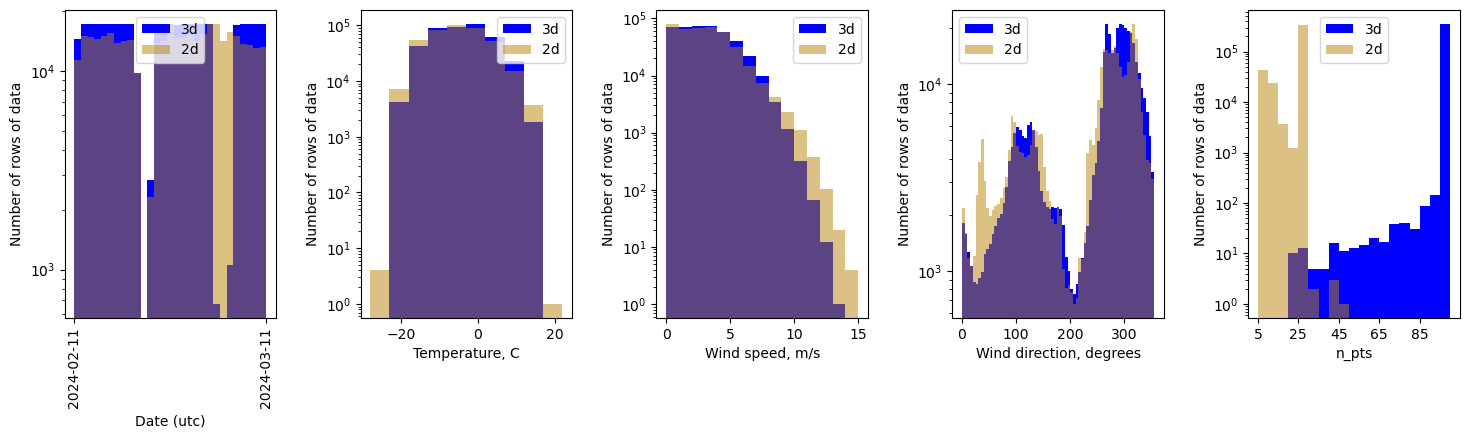

In [66]:
fig, axes = plt.subplots(1,5, figsize=(18,4))
fig.subplots_adjust(wspace=.4)

# Histogram of dates
ax = axes[0]
# Create a list of dates
start_date = min(min(data_2d['time_utc'].dt.date), min(data_3d['time_utc'].dt.date))
end_date = max(max(data_2d['time_utc'].dt.date), max(data_3d['time_utc'].dt.date))
dates = [(start_date + timedelta(days=x)).strftime('%Y-%m-%d') for x in range((end_date - start_date).days + 1)]
# Plot histogram
ax.hist(data_3d['time_utc'], bins = dates, color="blue", label="3d", alpha=1)
ax.hist(data_2d['time_utc'], bins = dates, color="darkgoldenrod", label="2d", alpha=0.5)
ax.set_xlabel('Date (utc)')  
ax.set_xticks([dates[0], dates[len(dates)-1]])
ax.tick_params(axis='x', rotation=90)
ax.set_ylabel('Number of rows of data') 
ax.set_yscale('log')
ax.legend()


# Histogram of temperature
ax = axes[1]
start_bin = int(np.floor(min(min(data_2d['temp_C']), min(data_3d['temp_C']))))
end_bin = int(np.ceil(max(max(data_2d['temp_C']), max(data_3d['temp_C']), )))
bin_limits = list(range(start_bin,end_bin, 5))
# Plot histogram
ax.hist(data_3d['temp_C'], bins=bin_limits, color="blue", label="3d", alpha=1)
ax.hist(data_2d['temp_C'], bins=bin_limits, color="darkgoldenrod", label="2d", alpha=0.5)
ax.set_xlabel('Temperature, C')  
ax.set_ylabel('Number of rows of data') 
ax.set_yscale('log')
ax.legend()


# Histogram of wind speeds
ax = axes[2]
start_bin = int(np.floor(min(min(data_2d['wspd_mps']), min(data_3d['wspd_mps']))))
end_bin = int(np.ceil(max(max(data_2d['wspd_mps']), max(data_3d['wspd_mps']))))
bin_limits = list(range(start_bin,end_bin, 1))
# Plot histogram
ax.hist(data_3d['wspd_mps'], bins=bin_limits, color="blue", label="3d", alpha=1)
ax.hist(data_2d['wspd_mps'], bins=bin_limits, color="darkgoldenrod", label="2d", alpha=0.5)
ax.set_xlabel('Wind speed, m/s')  
ax.set_ylabel('Number of rows of data') 
ax.set_yscale('log')
ax.legend()


# Histogram of wind directions
ax = axes[3]
start_bin = int(np.floor(min(min(data_2d['wdr']), min(data_3d['wdr']))))
end_bin = int(np.ceil(max(max(data_2d['wdr']), max(data_3d['wdr']))))
bin_limits = list(range(start_bin,end_bin, 5))
# Plot histogram
ax.hist(data_3d['wdr'], bins=bin_limits, color="blue", label="3d", alpha=1)
ax.hist(data_2d['wdr'], bins=bin_limits, color="darkgoldenrod", label="2d", alpha=0.5)
ax.set_xlabel('Wind direction, degrees')  
ax.set_ylabel('Number of rows of data') 
ax.set_yscale('log')
ax.legend()

# Histogram of n_pts
ax = axes[4]
start_bin = int(np.floor(min(min(data_2d['n_pts']), min(data_3d['n_pts']))))
end_bin = int(np.ceil(max(max(data_2d['n_pts']), max(data_3d['n_pts']))))
bin_limits = list(range(start_bin,end_bin, 5))
# Plot histogram
ax.hist(data_3d['n_pts'], bins=bin_limits, color="blue", label="3d", alpha=1)
ax.hist(data_2d['n_pts'], bins=bin_limits, color="darkgoldenrod", label="2d", alpha=0.5)
ax.set_xlabel('n_pts')  
ax.set_ylabel('Number of rows of data') 
ax.set_yscale('log')
ax.set_xticks(list(range(start_bin,end_bin, 20)))
ax.legend()

plt.savefig("output/cleaned_data_histograms.png", bbox_inches='tight')
plt.show()

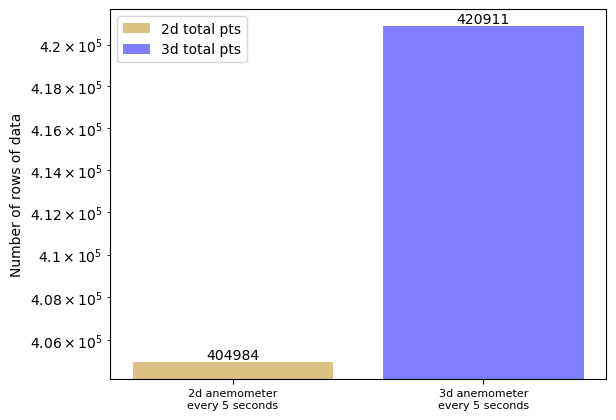

In [67]:
# Histogram of dataset sizes
dataset_sizes = [len(data_2d),len(data_3d)]
bars = plt.bar(['2d anemometer\nevery 5 seconds',
                 '3d anemometer\nevery 5 seconds'], 
                 dataset_sizes, color=["darkgoldenrod","blue"],alpha=0.5,
                 label=["2d total pts","3d total pts"])
# plt.xlabel('dataset')
plt.xticks(fontsize=8)
plt.ylabel('Number of rows of data')
plt.yscale('log')
plt.legend()
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), 
             ha='center', va='bottom')  # va='bottom' to place label above the bar
plt.savefig("output/cleaned_data_number_data_points.png", bbox_inches='tight')
plt.show()

In [68]:
# Save the cleaned data for future use
data_2d.to_csv('data/2d_anemometer_cleaned.csv', index=False)  
data_3d.to_csv('data/3d_anemometer_cleaned.csv', index=False)  

## Add columns
Add columns to be used for analysis.

In [ ]:
# Add local time, date, and hour to 2d anemometer data
data_2d['time_local'] = data_2d['time_utc'] - timedelta(hours=6)
data_2d['date'] = data_2d['time_local'].dt.date
data_2d = data_2d.astype({'date': 'datetime64[ns]'})
data_2d['hour'] = data_2d['time_local'].dt.hour
data_2d['minute'] = data_2d['time_local'].dt.minute

# Add local time, date, and hour to 3d anemometer data
data_3d['time_local'] = data_3d['time_utc'] - timedelta(hours=6)
data_3d['date'] = data_3d['time_local'].dt.date
data_3d = data_3d.astype({'date': 'datetime64[ns]'})
data_3d['hour'] = data_3d['time_local'].dt.hour
data_3d['minute'] = data_3d['time_local'].dt.minute

# Date range 
print("Date range for 2d anemometer (local time):")
print(f"Min: {min(data_2d['time_local'])}")
print(f"Max: {max(data_2d['time_local'])}")
print("Date range for 3d anemometer (local time):")
print(f"Min: {min(data_3d['time_local'])}")
print(f"Max: {max(data_3d['time_local'])}")

Date range for 2d anemometer (local time):
Min: 2024-02-10 21:43:59
Max: 2024-03-11 11:01:27
Date range for 3d anemometer (local time):
Min: 2024-02-10 21:44:04
Max: 2024-03-11 11:03:45


In [ ]:
# Establish the bins
minute_bin = list(np.arange(0,61,15)) # [0, 15, 30, 45, 60]

# Use `pd.cut` to find minute bins
data_2d["minute_bin"] = pd.cut(data_2d["minute"], 
                                bins = minute_bin, 
                                include_lowest = True,
                                right = False)
data_3d["minute_bin"] = pd.cut(data_3d["minute"], 
                                bins = minute_bin, 
                                include_lowest = True,
                                right = False)

In [ ]:
# Find cosine and sine of wind directions (for future averaging using vector components)
data_2d["wdr_cos"] = np.cos(data_2d["wdr"]*math.pi/180)
data_2d["wdr_sin"] = np.sin(data_2d["wdr"]*math.pi/180)
data_3d["wdr_cos"] = np.cos(data_3d["wdr"]*math.pi/180)
data_3d["wdr_sin"] = np.sin(data_3d["wdr"]*math.pi/180)

In [ ]:
# Add a column for temperature in Fahrenheit
data_2d["temp_F"] = data_2d["temp_C"]*1.8+32
data_3d["temp_F"] = data_3d["temp_C"]*1.8+32
# Add a column for wind speed in mph
data_2d["wspd_mph"] = data_2d["wspd_mps"]*2.23694
data_3d["wspd_mph"] = data_3d["wspd_mps"]*2.23694

In [ ]:
# Show first five rows
data_2d.head()

,n_pts,temp_C,time_utc,wdr,wspd_mps,time_local,date,hour,minute,minute_bin,wdr_cos,wdr_sin,temp_F,wspd_mph
0,7,-9.20,2024-02-15 16:19:32,332.45,4.371919,2024-02-15 10:19:32,2024-02-15,10,19,"[15, 30)",0.886608,-0.462523,15.440,9.779721
1,10,-9.20,2024-02-15 16:19:37,334.20,4.408201,2024-02-15 10:19:37,2024-02-15,10,19,"[15, 30)",0.900319,-0.435231,15.440,9.860881
2,24,-10.10,2024-02-11 03:43:59,233.97,1.161008,2024-02-10 21:43:59,2024-02-10,21,43,"[30, 45)",-0.588209,-0.808709,13.820,2.597104
3,25,-10.12,2024-02-11 03:44:04,235.52,0.911572,2024-02-10 21:44:04,2024-02-10,21,44,"[30, 45)",-0.566119,-0.824324,13.784,2.039133
4,25,-10.20,2024-02-11 03:44:09,237.92,0.816333,2024-02-10 21:44:09,2024-02-10,21,44,"[30, 45)",-0.531103,-0.847307,13.640,1.826089


In [ ]:
# Show first five rows
data_3d.head()

,n_pts,temp_C,time_utc,wdr,welv,wspd_mps,time_local,date,hour,minute,minute_bin,wdr_cos,wdr_sin,temp_F,wspd_mph
0,102,-7.18,2024-02-20 13:36:40,301.86,-3.15,0.479275,2024-02-20 07:36:40,2024-02-20,7,36,"[30, 45)",0.527846,-0.849340,19.076,1.072109
1,100,-7.16,2024-02-20 13:36:35,308.80,-0.70,0.379972,2024-02-20 07:36:35,2024-02-20,7,36,"[30, 45)",0.626604,-0.779338,19.112,0.849974
2,100,-7.13,2024-02-20 13:36:30,313.35,-4.28,0.398884,2024-02-20 07:36:30,2024-02-20,7,36,"[30, 45)",0.686453,-0.727174,19.166,0.892281
3,99,-7.16,2024-02-20 13:36:25,321.01,-4.78,0.488296,2024-02-20 07:36:25,2024-02-20,7,36,"[30, 45)",0.777256,-0.629185,19.112,1.092288
4,98,-7.17,2024-02-20 13:36:20,323.81,-1.89,0.579684,2024-02-20 07:36:20,2024-02-20,7,36,"[30, 45)",0.807063,-0.590465,19.094,1.296719


## Join data on 15-min intervals for 3d anemometer (since that is the interval of LongPath anemometer averaging)

In [ ]:
# Average wind speed and wind direction over 15 min intervals
data_2d_15min = data_2d.groupby(['date', 'hour','minute_bin'],as_index=False,observed=False)[['wspd_mps','wspd_mph','wdr_cos','wdr_sin','temp_C','temp_F']].mean()
data_2d_15min.dropna(inplace=True)
data_3d_15min = data_3d.groupby(['date', 'hour','minute_bin'],as_index=False,observed=False)[['wspd_mps','wspd_mph','wdr_cos','wdr_sin','welv','temp_C','temp_F']].mean()
data_3d_15min.dropna(inplace=True)

# Compute wind direction from vector components
data_2d_15min['wdr'] = (np.arctan2(data_2d_15min['wdr_sin'],data_2d_15min['wdr_cos']) * 180 / np.pi) % 360
data_3d_15min['wdr'] = (np.arctan2(data_3d_15min['wdr_sin'],data_3d_15min['wdr_cos']) * 180 / np.pi) % 360


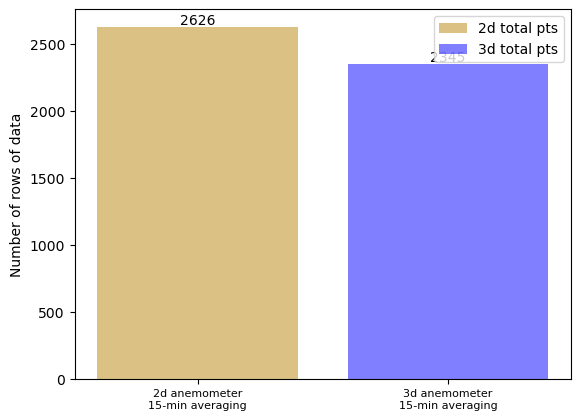

In [ ]:
# Histogram of dataset sizes

dataset1_sizes = [len(data_2d_15min),len(data_3d_15min)]
dataset2_sizes = [len(data_2d_15min)/6, len(data_3d_15min)/6]
bars = plt.bar(['2d anemometer\n15-min averaging',
                '3d anemometer\n15-min averaging'],
                 dataset1_sizes, color=["darkgoldenrod","blue"], alpha=.5,
                 label=["2d total pts","3d total pts"])
#plt.xlabel('dataset')
plt.xticks(fontsize=8)
plt.legend()
plt.ylabel('Number of rows of data')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), 
             ha='center', va='bottom')  # va='bottom' to place label above the bar
plt.savefig("output/cleaned_data_15_min_avg_number_data_points.png", bbox_inches='tight')
plt.show()

In [ ]:
# Check that wind direction calculation works as expected
demo_angle = 333
demo_sin_angle = np.sin(demo_angle*math.pi/180)
demo_cos_angle = np.cos(demo_angle*math.pi/180)
demo_wdr1 = (np.arctan2(demo_sin_angle,demo_cos_angle) * 180 / np.pi) % 360
demo_wdr2 = (180/math.pi)*np.arctan(demo_sin_angle/demo_cos_angle)+(demo_cos_angle<0)*180+( (demo_cos_angle>=0) & (demo_sin_angle<0) )*360
print(demo_wdr1)
print(demo_wdr2)

333.0
333.0


In [ ]:
# Check that wind direction calculation works as expected
demo_u = 1
demo_v = 1
demo_wdr3 = (np.arctan2(-demo_u,-demo_v) * 180 / np.pi) % 360
print(demo_wdr3)

225.0


In [ ]:

# Merged dataframe of 2d and 3d anemometer data
df_2d_and_3d = pd.merge(data_2d_15min, data_3d_15min, how = 'outer', on = ['date','hour','minute_bin'], suffixes=('_2d', '_3d'))
df_2d_and_3d['wspd_mps_diff'] = df_2d_and_3d['wspd_mps_2d'] - df_2d_and_3d['wspd_mps_3d']
df_2d_and_3d['wspd_mph_diff'] = df_2d_and_3d['wspd_mph_2d'] - df_2d_and_3d['wspd_mph_3d']
df_2d_and_3d['wdr_diff'] = df_2d_and_3d['wdr_2d'] - df_2d_and_3d['wdr_3d'] + (df_2d_and_3d['wdr_2d'] - df_2d_and_3d['wdr_3d']<-180)*360 -  (df_2d_and_3d['wdr_2d'] - df_2d_and_3d['wdr_3d']>180)*360
df_2d_and_3d['temp_C_diff'] = df_2d_and_3d['temp_C_2d'] - df_2d_and_3d['temp_C_3d']
df_2d_and_3d['temp_F_diff'] = df_2d_and_3d['temp_F_2d'] - df_2d_and_3d['temp_F_3d']
df_2d_and_3d['wdr_3d_by10'] = round(df_2d_and_3d['wdr_3d'],-1)
df_2d_and_3d['wspd_mps_3d_by1'] = round(df_2d_and_3d['wspd_mps_3d'],0)
df_2d_and_3d['wspd_mph_3d_by1'] = round(df_2d_and_3d['wspd_mph_3d'],0)
df_2d_and_3d['temp_F_3d_by1'] = round(df_2d_and_3d['temp_F_3d'],0)

In [ ]:
# Add or subtract 360 from wind direction for regression
df_2d_and_3d['wdr_3d_corr'] = df_2d_and_3d['wdr_3d'] 
df_2d_and_3d['wdr_3d_corr'] = df_2d_and_3d['wdr_3d_corr'] + (df_2d_and_3d['wdr_3d_corr']-df_2d_and_3d['wdr_2d']<-180)*360 - (df_2d_and_3d['wdr_3d_corr']-df_2d_and_3d['wdr_2d']>180)*360

In [ ]:
# Save the dataframes for use in multilinear regression 
df_2d_and_3d_for_pgadmin = df_2d_and_3d.copy()
df_2d_and_3d_for_pgadmin.dropna(inplace=True)
df_2d_and_3d_for_pgadmin.to_csv('data/df_2d_and_3d.csv', index=True, index_label='index')  

## Analysis 2d vs 3d Anemometers

In [ ]:
# Create dataframes of mean wind speed difference, wind direction difference, temp difference per 3d wind direction, wind speed, kinetic energy
diff_2d_3d_per_wdr_3d = df_2d_and_3d.groupby(['wdr_3d_by10'],as_index=False,observed=False)[['wspd_mps_diff','wspd_mph_diff','wdr_diff','temp_C_diff','temp_F_diff']].mean()
diff_2d_3d_per_wspd_3d = df_2d_and_3d.groupby(['wspd_mph_3d_by1'],as_index=False,observed=False)[['wspd_mph_diff','wdr_diff','temp_C_diff','temp_F_diff']].mean()
diff_2d_3d_per_temp_3d = df_2d_and_3d.groupby(['temp_F_3d_by1'],as_index=False,observed=False)[['wspd_mph_diff','wdr_diff','temp_C_diff','temp_F_diff']].mean()

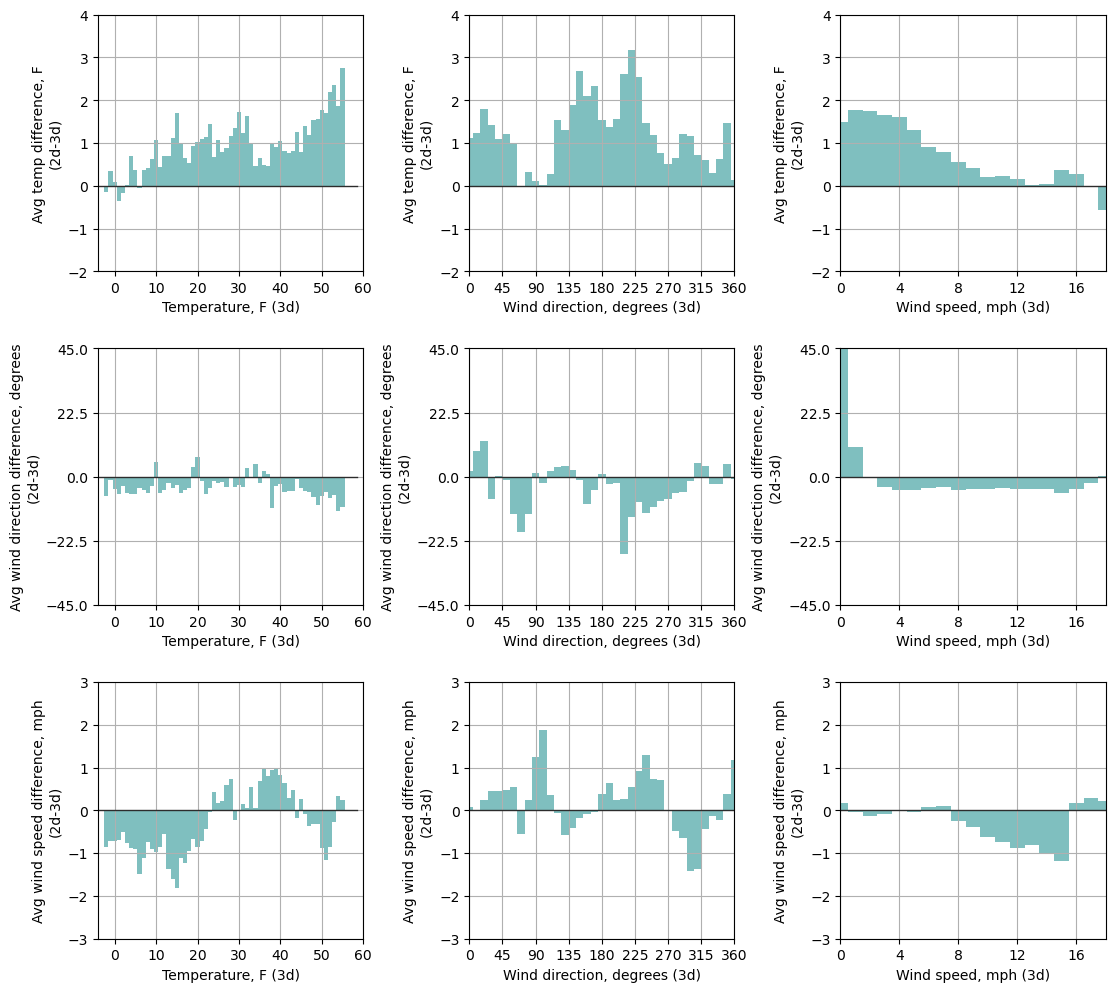

In [ ]:
fig, axes = plt.subplots(3,3, figsize=(13,12))
#fig.tight_layout()
fig.subplots_adjust(hspace=.3)
fig.subplots_adjust(wspace=.4)

ax = axes[0,0]
ax.bar(diff_2d_3d_per_temp_3d['temp_F_3d_by1'], diff_2d_3d_per_temp_3d['temp_F_diff'], width=1, color="teal", alpha=.5, label="2d-3d")
# plot line y=0
ax.plot([np.min(ax.get_xlim()),np.max(ax.get_xlim())], [0,0], 'k-', alpha=0.75, zorder=2, lw=1)
ax.set_xlim([-4,60])
ax.set_xticks([0,10,20,30,40,50,60])
ax.set_ylim([-2,4])
ax.set_yticks([-2,-1,0,1,2,3,4])
ax.grid(True) 
ax.set_xlabel('Temperature, F (3d)')
ax.set_ylabel('Avg temp difference, F\n(2d-3d)')

ax = axes[1,0]
ax.bar(diff_2d_3d_per_temp_3d['temp_F_3d_by1'], diff_2d_3d_per_temp_3d['wdr_diff'], width=1, color="teal", alpha=.5, label="2d-3d")
# plot line y=0
ax.plot([np.min(ax.get_xlim()),np.max(ax.get_xlim())], [0,0], 'k-', alpha=0.75, zorder=2, lw=1)
ax.set_xlim([-4,60])
ax.set_xticks([0,10,20,30,40,50,60])
ax.set_ylim([-45,45])
ax.set_yticks([-45,-22.5,0,22.5,45])
ax.grid(True) 
ax.set_xlabel('Temperature, F (3d)')
ax.set_ylabel('Avg wind direction difference, degrees\n(2d-3d)')

ax = axes[2,0]
ax.bar(diff_2d_3d_per_temp_3d['temp_F_3d_by1'], diff_2d_3d_per_temp_3d['wspd_mph_diff'], width=1, color="teal", alpha=.5, label="2d-3d")
# plot line y=0
ax.plot([np.min(ax.get_xlim()),np.max(ax.get_xlim())], [0,0], 'k-', alpha=0.75, zorder=2, lw=1)
ax.set_xlim([-4,60])
ax.set_xticks([0,10,20,30,40,50,60])
ax.set_ylim([-3,3])
ax.set_yticks([-3,-2,-1,0,1,2,3])
ax.grid(True) 
ax.set_xlabel('Temperature, F (3d)')
ax.set_ylabel('Avg wind speed difference, mph\n(2d-3d)')

ax = axes[0,1]
ax.bar(diff_2d_3d_per_wdr_3d['wdr_3d_by10'], diff_2d_3d_per_wdr_3d['temp_F_diff'], width=10, color="teal", alpha=.5, label="2d-3d")
# plot line y=0
ax.plot([np.min(ax.get_xlim()),np.max(ax.get_xlim())], [0,0], 'k-', alpha=0.75, zorder=2, lw=1)
ax.set_xlim([0,360])
ax.set_xticks([0,45,90,135,180,225,270,315,360])
ax.set_ylim([-2,4])
ax.set_yticks([-2,-1,0,1,2,3,4])
ax.grid(True) 
ax.set_xlabel('Wind direction, degrees (3d)')
ax.set_ylabel('Avg temp difference, F\n(2d-3d)')

ax = axes[1,1]
ax.bar(diff_2d_3d_per_wdr_3d['wdr_3d_by10'], diff_2d_3d_per_wdr_3d['wdr_diff'], width=10, color="teal", alpha=.5, label="2d-3d")
# plot line y=0
ax.plot([np.min(ax.get_xlim()),np.max(ax.get_xlim())], [0,0], 'k-', alpha=0.75, zorder=2, lw=1)
ax.set_xlim([0,360])
ax.set_xticks([0,45,90,135,180,225,270,315,360])
ax.set_ylim([-45,45])
ax.set_yticks([-45,-22.5,0,22.5,45])
ax.grid(True) 
ax.set_xlabel('Wind direction, degrees (3d)')
ax.set_ylabel('Avg wind direction difference, degrees\n(2d-3d)')


ax = axes[2,1]
ax.bar(diff_2d_3d_per_wdr_3d['wdr_3d_by10'], diff_2d_3d_per_wdr_3d['wspd_mph_diff'], width=10, color="teal", alpha=.5, label="2d-3d")
# plot line y=0
ax.plot([np.min(ax.get_xlim()),np.max(ax.get_xlim())], [0,0], 'k-', alpha=0.75, zorder=2, lw=1)
ax.set_xlim([0,360])
ax.set_xticks([0,45,90,135,180,225,270,315,360])
ax.set_ylim([-3,3])
ax.set_yticks([-3,-2,-1,0,1,2,3])
ax.grid(True) 
ax.set_xlabel('Wind direction, degrees (3d)')
ax.set_ylabel('Avg wind speed difference, mph\n(2d-3d)')


ax = axes[0,2]
ax.bar(diff_2d_3d_per_wspd_3d['wspd_mph_3d_by1'], diff_2d_3d_per_wspd_3d['temp_F_diff'], width=1, color="teal", alpha=.5, label="2d-3d")
# plot line y=0
ax.plot([np.min(ax.get_xlim()),np.max(ax.get_xlim())], [0,0], 'k-', alpha=0.75, zorder=2, lw=1)
ax.set_xlim([0,18])
ax.set_xticks([0,4,8,12,16])
ax.set_ylim([-2,4])
ax.set_yticks([-2,-1,0,1,2,3,4])
ax.grid(True) 
ax.set_xlabel('Wind speed, mph (3d)')
ax.set_ylabel('Avg temp difference, F\n(2d-3d)')

ax = axes[1,2]
ax.bar(diff_2d_3d_per_wspd_3d['wspd_mph_3d_by1'], diff_2d_3d_per_wspd_3d['wdr_diff'], width=1, color="teal", alpha=.5, label="2d-3d")
# plot line y=0
ax.plot([np.min(ax.get_xlim()),np.max(ax.get_xlim())], [0,0], 'k-', alpha=0.75, zorder=2, lw=1)
ax.set_xlim([0,18])
ax.set_xticks([0,4,8,12,16])
ax.set_ylim([-45,45])
ax.set_yticks([-45,-22.5,0,22.5,45])
ax.grid(True) 
ax.set_xlabel('Wind speed, mph (3d)')
ax.set_ylabel('Avg wind direction difference, degrees\n(2d-3d)')

ax = axes[2,2]
ax.bar(diff_2d_3d_per_wspd_3d['wspd_mph_3d_by1'], diff_2d_3d_per_wspd_3d['wspd_mph_diff'], width=1, color="teal", alpha=.5, label="2d-3d")
# plot line y=0
ax.plot([np.min(ax.get_xlim()),np.max(ax.get_xlim())], [0,0], 'k-', alpha=0.75, zorder=2, lw=1)
ax.set_xlim([0,18])
ax.set_xticks([0,4,8,12,16])
ax.set_ylim([-3,3])
ax.set_yticks([-3,-2,-1,0,1,2,3])
ax.grid(True) 
ax.set_xlabel('Wind speed, mph (3d)')
ax.set_ylabel('Avg wind speed difference, mph\n(2d-3d)')


plt.savefig("output/diff_2d_3d_per_3d.png", bbox_inches='tight')
plt.show()


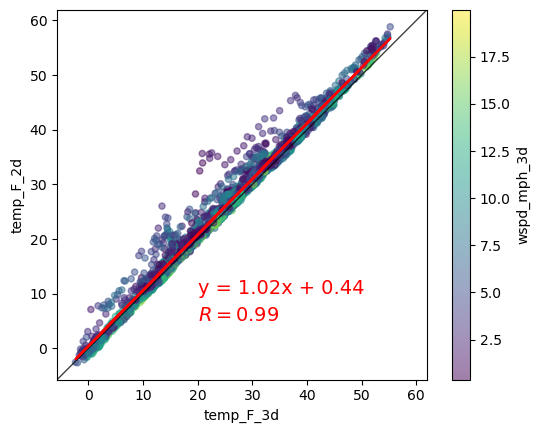

In [ ]:
# Scatterplot of temp 3d vs 2d
ax = df_2d_and_3d.plot.scatter(x='temp_F_3d',y='temp_F_2d', c='wspd_mph_3d', cmap="viridis", alpha=.5)

# plot line y=x
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
        ]
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=2, lw=1)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

# Find regression model using linregress in scripy.stats
xdata = df_2d_and_3d["temp_F_3d"]
ydata = df_2d_and_3d["temp_F_2d"]
mask = ~np.isnan(xdata) & ~np.isnan(ydata)
slope, intercept, rvalue, pvalue, stderr = st.linregress(xdata[mask], ydata[mask])  # rvalue is the correlation coefficient, rvalue^2 is coefficeint of determination
ylinreg = slope*xdata + intercept # regression values

# plot regression model and correlation coefficient on scatterplot
ax.plot(xdata, ylinreg, '-r')
ax.text(20, 5,'$R = %0.2f$'% rvalue, fontsize = 14, color='red')
ax.text(20, 10,f'y = {slope:0.2f}x + {intercept:0.2f}', fontsize = 14, color='red')

plt.savefig("output/reg_temp_2d_3d.png",bbox_inches='tight')
plt.show()

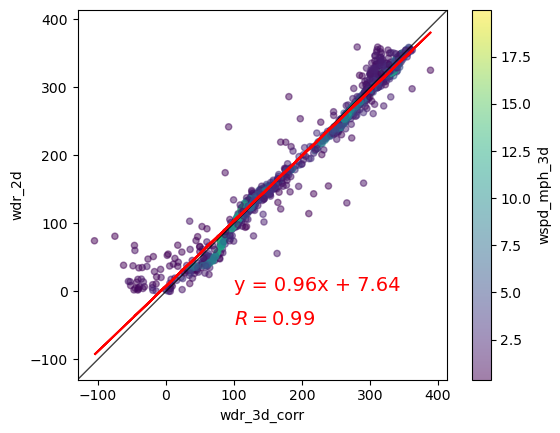

In [ ]:
# Scatterplot of temp 3d vs 2d
ax = df_2d_and_3d.plot.scatter(x='wdr_3d_corr',y='wdr_2d', c='wspd_mph_3d', cmap="viridis", alpha=.5)

# plot line y=x
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
        ]
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=2, lw=1)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

# Find regression model using linregress in scripy.stats
xdata = df_2d_and_3d["wdr_3d_corr"]
ydata = df_2d_and_3d["wdr_2d"]
mask = ~np.isnan(xdata) & ~np.isnan(ydata)
slope, intercept, rvalue, pvalue, stderr = st.linregress(xdata[mask], ydata[mask])  # rvalue is the correlation coefficient, rvalue^2 is coefficeint of determination
ylinreg = slope*xdata + intercept # regression values

# plot regression model and correlation coefficient on scatterplot
ax.plot(xdata, ylinreg, '-r')
ax.text(100, -50,'$R = %0.2f$'% rvalue, fontsize = 14, color='red')
ax.text(100, 0,f'y = {slope:0.2f}x + {intercept:0.2f}', fontsize = 14, color='red')

plt.savefig("output/reg_wdr_2d_3d.png",bbox_inches='tight')
plt.show()

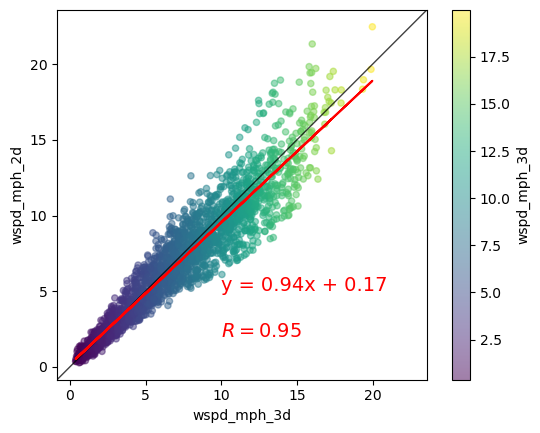

In [ ]:
# Scatterplot of temp 3d vs 2d
ax = df_2d_and_3d.plot.scatter(x='wspd_mph_3d',y='wspd_mph_2d', c='wspd_mph_3d', cmap="viridis", alpha=.5)

# plot line y=x
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
        ]
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=2, lw=1)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

# Find regression model using linregress in scripy.stats
xdata = df_2d_and_3d["wspd_mph_3d"]
ydata = df_2d_and_3d["wspd_mph_2d"]
mask = ~np.isnan(xdata) & ~np.isnan(ydata)
slope, intercept, rvalue, pvalue, stderr = st.linregress(xdata[mask], ydata[mask])  # rvalue is the correlation coefficient, rvalue^2 is coefficeint of determination
ylinreg = slope*xdata + intercept # regression values

# plot regression model and correlation coefficient on scatterplot
ax.plot(xdata, ylinreg, '-r')
ax.text(10, 2,'$R = %0.2f$'% rvalue, fontsize = 14, color='red')
ax.text(10, 5,f'y = {slope:0.2f}x + {intercept:0.2f}', fontsize = 14, color='red')

plt.savefig("output/reg_wspd_2d_3d.png", bbox_inches='tight')
plt.show()

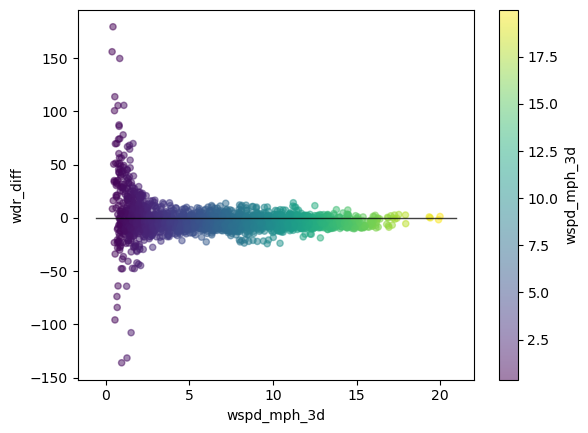

In [ ]:
# Scatterplot of wind direction diff vs wind speed
ax = df_2d_and_3d.plot.scatter(x='wspd_mph_3d',y='wdr_diff', c='wspd_mph_3d', alpha=.5)
# plot line y=0
ax.plot([np.min(ax.get_xlim()),np.max(ax.get_xlim())], [0,0], 'k-', alpha=0.75, zorder=2, lw=1)

plt.savefig("output/wdr_diff_2d_3d_wspd.png", bbox_inches='tight')
plt.show()

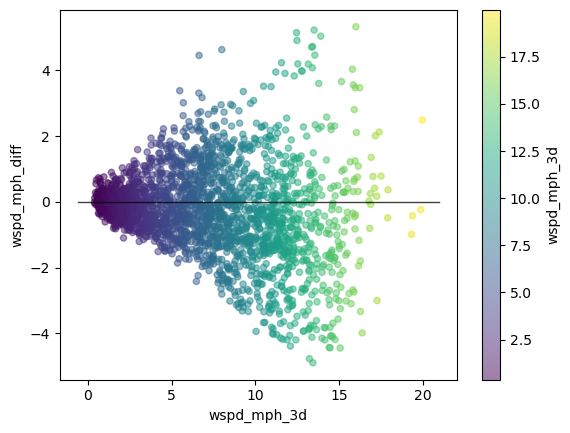

In [ ]:
# Scatterplot of wind direction diff vs wind speed
ax = df_2d_and_3d.plot.scatter(x='wspd_mph_3d',y='wspd_mph_diff', c='wspd_mph_3d', alpha=.5)
# plot line y=0
ax.plot([np.min(ax.get_xlim()),np.max(ax.get_xlim())], [0,0], 'k-', alpha=0.75, zorder=2, lw=1)

plt.savefig("output/wspd_diff_2d_3d_wspd.png", bbox_inches='tight')
plt.show()

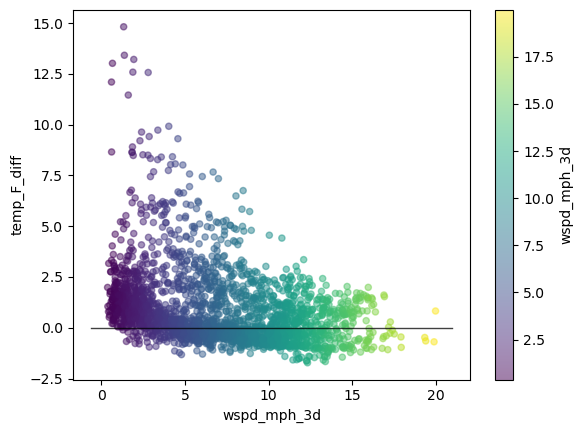

In [ ]:
# Scatterplot of wind direction diff vs wind speed
ax = df_2d_and_3d.plot.scatter(x='wspd_mph_3d',y='temp_F_diff', c='wspd_mph_3d', alpha=.5)
# plot line y=0
ax.plot([np.min(ax.get_xlim()),np.max(ax.get_xlim())], [0,0], 'k-', alpha=0.75, zorder=2, lw=1)

plt.savefig("output/temp_diff_2d_3d_wspd.png", bbox_inches='tight')
plt.show()

Average temperature diff: 0.9076460639448031 F
Average wind direction diff: -2.4655796951063302 degrees
Average wind speed diff: -0.2738139282956635 mph


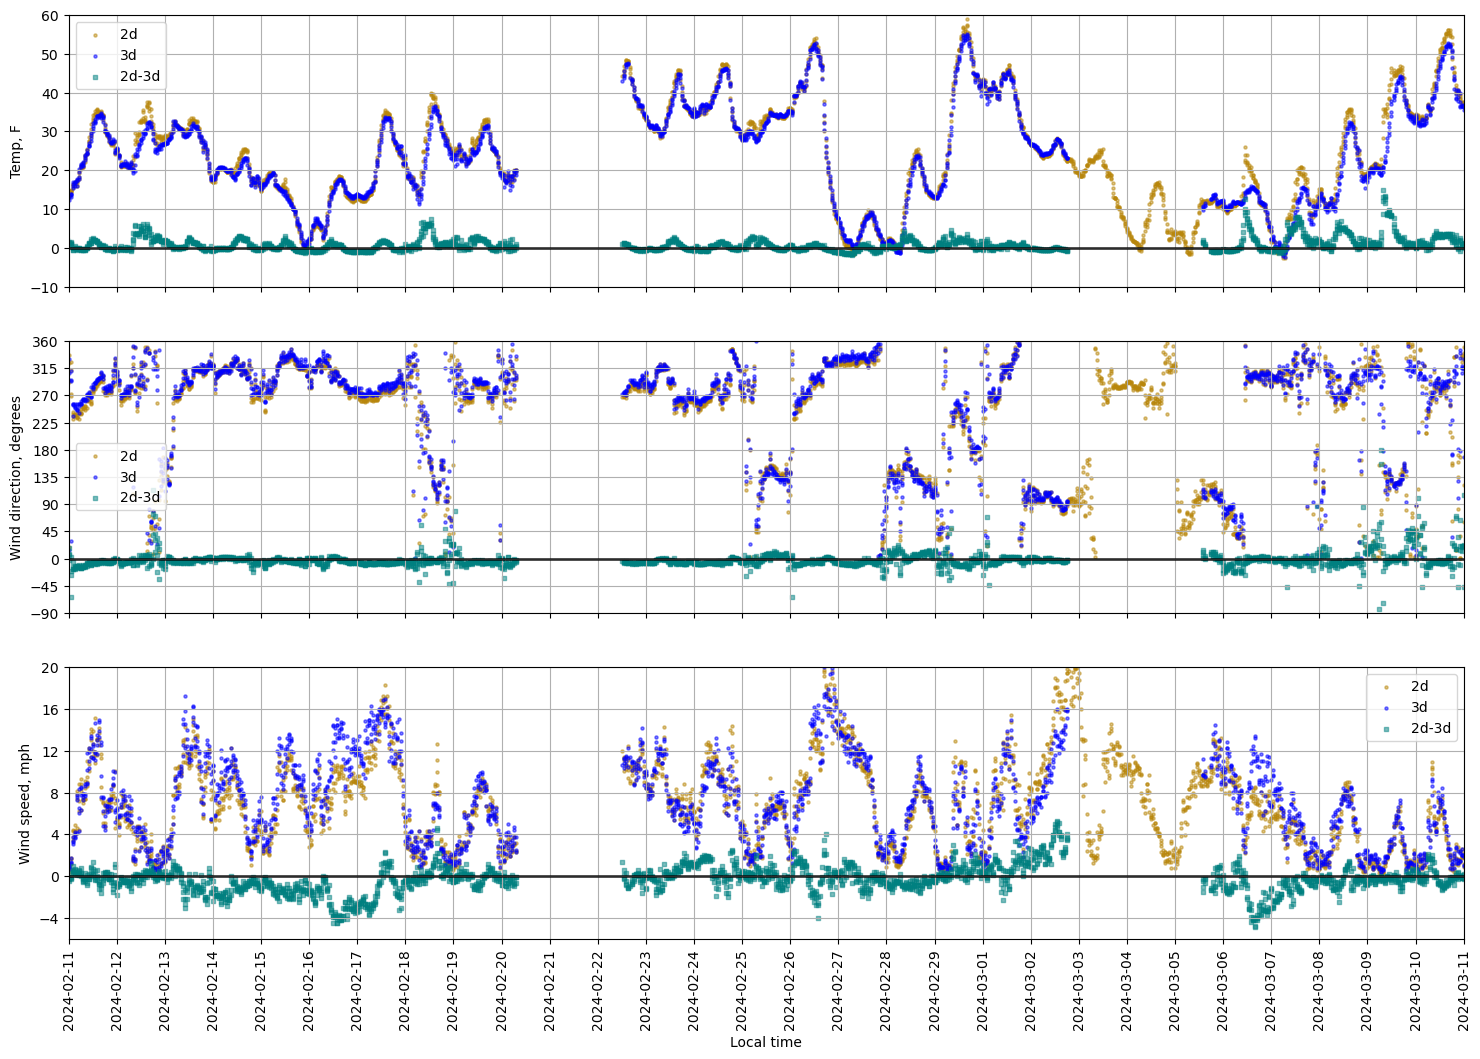

In [ ]:
fig, axes = plt.subplots(3,1, figsize=(18,12))

# Create a list of dates, 2024-02-11 to 2024-03-11
start_date = datetime(2024, 2, 11)
end_date = datetime(2024, 3, 11)
dates = [(start_date + timedelta(days=x)).strftime('%Y-%m-%d') for x in range((end_date - start_date).days + 1)]

ax = axes[0] 
ax.scatter(pd.to_datetime(df_2d_and_3d['date']) + pd.to_timedelta(df_2d_and_3d['hour'], unit='h'), 
           df_2d_and_3d[f'temp_F_2d'], alpha=0.5, c='darkgoldenrod', s=5, marker='o', label=f'2d')
ax.scatter(pd.to_datetime(df_2d_and_3d['date']) + pd.to_timedelta(df_2d_and_3d['hour'], unit='h'), 
            df_2d_and_3d[f'temp_F_3d'], alpha=0.5, c='blue', s=5, marker='o', label=f'3d')
ax.scatter(pd.to_datetime(df_2d_and_3d['date']) + pd.to_timedelta(df_2d_and_3d['hour'], unit='h'), 
            df_2d_and_3d[f'temp_F_diff'], alpha=0.5, c='teal', s=5, marker='s', label=f'2d-3d')
ax.legend()
ax.set_ylim([-10,60])
ax.set_yticks([-10,0,10,20,30,40,50,60])
ax.set_xticks(dates)
ax.set_xticklabels([])
ax.grid(True) 
# plot line y=0
ax.plot([np.min(ax.get_xlim()),np.max(ax.get_xlim())], [0,0], 'k-', alpha=0.75, zorder=2, lw=2) 
# ax.set_xlabel('Local time')
ax.set_ylabel('Temp, F')
ax.set_xlim([pd.to_datetime('02/11/2024'),pd.to_datetime('03/11/2024')])

ax = axes[1] 
ax.scatter(pd.to_datetime(df_2d_and_3d['date']) + pd.to_timedelta(df_2d_and_3d['hour'], unit='h'), 
            df_2d_and_3d[f'wdr_2d'], alpha=0.5, c='darkgoldenrod', s=5, marker='o', label=f'2d')
ax.scatter(pd.to_datetime(df_2d_and_3d['date']) + pd.to_timedelta(df_2d_and_3d['hour'], unit='h'), 
            df_2d_and_3d[f'wdr_3d'], alpha=0.5, c='blue', s=5, marker='o', label=f'3d')
ax.scatter(pd.to_datetime(df_2d_and_3d['date']) + pd.to_timedelta(df_2d_and_3d['hour'], unit='h'), 
            df_2d_and_3d[f'wdr_diff'], alpha=0.5, c='teal', s=5, marker='s', label=f'2d-3d')
ax.legend()
ax.set_ylim([-90,360])
ax.set_yticks([-90,-45,0,45,90,135,180,225,270,315,360])
ax.set_xticks(dates)
ax.set_xticklabels([])
ax.grid(True) 
# plot line y=0
ax.plot([np.min(ax.get_xlim()),np.max(ax.get_xlim())], [0,0], 'k-', alpha=0.75, zorder=2, lw=2) 
# ax.set_xlabel('')
ax.set_ylabel('Wind direction, degrees')
ax.set_xlim([pd.to_datetime('02/11/2024'),pd.to_datetime('03/11/2024')])

ax = axes[2] 
ax.scatter(pd.to_datetime(df_2d_and_3d['date']) + pd.to_timedelta(df_2d_and_3d['hour'], unit='h'), 
            df_2d_and_3d[f'wspd_mph_2d'], alpha=0.5, c='darkgoldenrod', s=5, marker='o', label=f'2d')
ax.scatter(pd.to_datetime(df_2d_and_3d['date']) + pd.to_timedelta(df_2d_and_3d['hour'], unit='h'), 
            df_2d_and_3d[f'wspd_mph_3d'], alpha=0.5, c='blue', s=5, marker='o', label=f'3d')
ax.scatter(pd.to_datetime(df_2d_and_3d['date']) + pd.to_timedelta(df_2d_and_3d['hour'], unit='h'), 
            df_2d_and_3d[f'wspd_mph_diff'], alpha=0.5, c='teal', s=5, marker='s', label=f'2d-3d')
ax.legend()
ax.set_ylim([-6,20])
ax.set_yticks([-4,0,4,8,12,16,20])
ax.grid(True) 
# plot line y=0
ax.plot([np.min(ax.get_xlim()),np.max(ax.get_xlim())], [0,0], 'k-', alpha=0.75, zorder=2, lw=2) 
# ax.set_xlabel('Local time')
ax.set_ylabel('Wind speed, mph')
ax.set_xlim([pd.to_datetime('02/11/2024'),pd.to_datetime('03/11/2024')])

ax.set_xticks(dates)
ax.set_xlabel('Local time')
plt.xticks(rotation=90)

print(f"Average temperature diff: {df_2d_and_3d['temp_F_diff'].mean()} F")
print(f"Average wind direction diff: {df_2d_and_3d['wdr_diff'].mean()} degrees")
print(f"Average wind speed diff: {df_2d_and_3d['wspd_mph_diff'].mean()} mph")

plt.savefig(f"output/2d_and_3d_timeseries.png", bbox_inches='tight')
plt.show()